In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML
import os
%matplotlib inline

In [2]:
# Notebook Styling 
sns.set()
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format',lambda x: '%.5f' % x)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz
import graphviz
# Ensembles
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
g_cmap = sns.light_palette('seagreen', n_colors=10, as_cmap=True)

def param_heat_mapper(ax_, df_, ind_col, val_col, col_col, base_clfname, cmap=g_cmap):
    '''Formats a heatmap of model performance given two hyperparameters
    
    Args:
        ax_:                a matplotlib axes object to plot to
        df_:                a Pandas DataFrame containing results from GridSearch in 
                              a tidy format where column names = parameter names
        ind_col_, col_col_: a string contaning the name of the feature to map
        val_col:            a string contining the name of the value column to map
        base_clfname:       a string containing a title prefix
    '''
    logit_piv = df_.pivot(index=ind_col, values=val_col, columns=col_col)
    title_ = base_clfname + ' Params: ' + ind_col + ' and ' + col_col
    with plt.style.context('seaborn-whitegrid'):
        sns.heatmap(logit_piv, linewidths=0.0, annot=True, fmt='0.3f',
                    ax=ax_, cmap=cmap, robust=True, annot_kws={'size':16})
        ax_.set_title(title_, fontsize=14)
        ax_.set_xlabel('Param: ' + col_col, fontsize=14)
        ax_.set_ylabel('Param: ' + ind_col, fontsize=14)
        
def train_test_param_map(x_var_, y_var_, map_df_):
    '''Prints two heatmaps showing model performance for different hyperparameter combinations.
    
    Args:
        x_var_, y_var_:   strings containing the names of the parameters to be mapped
        map_df_:          a Pandas DataFrame containing results from GridSearch in a 
                            tidy format where column names = parameter names
    '''
    with plt.style.context('seaborn-whitegrid'):
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(14,6))
        param_heat_mapper(ax[0], map_df_, y_var_, 'mean_train_score', x_var_, '[Training_Data]')
        param_heat_mapper(ax[1], map_df_, y_var_, 'mean_test_score', x_var_, '[Testing_Data]')

# The Data

This data was supplied by [FiveThirtyEight](https://github.com/fivethirtyeight/data/tree/master/primary-candidates-2018).

In [6]:
CSV_PATH = os.path.join('data', 'fivethirtyeight', 'dem_candidates_2018_prim.csv')
df = pd.read_csv(CSV_PATH, encoding='latin1', parse_dates=['Race Primary Election Date'])
df.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Gender,Partisan Lean,Primary %,Won Primary,Race,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Obama Alum?
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,2018-06-05,Lost,None,None,Male,-28.88000,3.42000,No,Nonwhite,Yes,No,No,No,No,No
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,2018-06-05,Lost,None,None,Male,-28.88000,1.74000,No,White,No,Yes,No,No,No,No
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,2018-06-05,Lost,None,None,Male,-28.88000,3.27000,No,White,Yes,No,No,No,No,No
3,James C. Fields,AL,Governor of Alabama,Governor,Regular,2018-06-05,Lost,None,None,Male,-28.88000,8.00000,No,Nonwhite,Yes,No,Yes,No,No,No
4,Sue Bell Cobb,AL,Governor of Alabama,Governor,Regular,2018-06-05,Lost,None,None,Female,-28.88000,28.98000,No,White,No,No,Yes,No,No,No


In [7]:
# is all of the data for completed races?
sum(df['Race Primary Election Date'] > pd.datetime.now())

0

From this, we see that all of the included primaries have already occurred (none of them happened after today).

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 20 columns):
Candidate                     811 non-null object
State                         811 non-null object
District                      811 non-null object
Office Type                   811 non-null object
Race Type                     811 non-null object
Race Primary Election Date    811 non-null datetime64[ns]
Primary Status                807 non-null object
Primary Runoff Status         811 non-null object
General Status                807 non-null object
Gender                        811 non-null object
Partisan Lean                 811 non-null float64
Primary %                     801 non-null float64
Won Primary                   785 non-null object
Race                          655 non-null object
Veteran?                      800 non-null object
LGBTQ?                        800 non-null object
Elected Official?             800 non-null object
Self-Funder?                  811 n

From the data info printout above, we see that the data set has 811 entries, and some features have fewer than 811 non-null entries, meaning those features have missing data. We also see that most features have the 'object' datatype, which we'll have to inspect. From the names and the table above, we see that most of these 'object' features are categorical features, which we can represent with a much smaller datatype (which allows algorithms to process the data faster).

In [9]:
cols = ['Office Type', 'Race Type', 'Primary Status', 'Primary Runoff Status',
       'General Status', 'Gender',  'Won Primary',
       'Race', 'Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?',
       'STEM?', 'Obama Alum?']
for feature in cols:
    print('Feature: {:^21s}; # of Unique Vals: {};  Unique Values: {}'
          .format(feature, len(df[feature].unique()), df[feature].unique()))

Feature:      Office Type     ; # of Unique Vals: 3;  Unique Values: ['Governor' 'Representative' 'Senator']
Feature:       Race Type      ; # of Unique Vals: 2;  Unique Values: ['Regular' 'Special']
Feature:    Primary Status    ; # of Unique Vals: 3;  Unique Values: ['Lost' 'Advanced' nan]
Feature: Primary Runoff Status; # of Unique Vals: 4;  Unique Values: ['None' 'Lost' 'Advanced' 'On the Ballot']
Feature:    General Status    ; # of Unique Vals: 3;  Unique Values: ['None' 'On the Ballot' nan]
Feature:        Gender        ; # of Unique Vals: 2;  Unique Values: ['Male' 'Female']
Feature:      Won Primary     ; # of Unique Vals: 3;  Unique Values: ['No' 'Yes' nan]
Feature:         Race         ; # of Unique Vals: 3;  Unique Values: ['Nonwhite' 'White' nan]
Feature:       Veteran?       ; # of Unique Vals: 3;  Unique Values: ['Yes' 'No' nan]
Feature:        LGBTQ?        ; # of Unique Vals: 3;  Unique Values: ['No' 'Yes' nan]
Feature:   Elected Official?  ; # of Unique Vals: 3;  Uniq

From a quick inspection of the data, we see that all of the above features are categorical. 

2 of the features ('Office Type' and 'Primary Runoff Status') are multicategory features, while the remainder are binary features, although most of them have missing values that need to be addressed.

#### Duplicates

It's important to confirm that the dataset doesn't contain duplicated rows. I reason that if a candidate is running for multiple positions or in multiple races, they can only occupy one roll, so a win in any race indicates they were a winning candidate. In any case, it's unlikely that multiple candidates with the same name would run in the same district (it would be like hanging-chad-gate times 100), so we should check our data. 

From the printout below, we see that 10 candidates match on both name and district. Per inspection, we see that these cases involve people running in both a regular and special election.  

In [10]:
no_dupes = len(df.loc[:,['Candidate','District']].drop_duplicates())
print('Without duplicated candidate names, there are {} entries in the data set'.format(no_dupes))
print('With duplicated candidate names, there are    {} entries in the data set'.format(len(df)))

Without duplicated candidate names, there are 801 entries in the data set
With duplicated candidate names, there are    811 entries in the data set


In [11]:
df[df.loc[:,['Candidate','District']].duplicated(keep=False)]

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Gender,Partisan Lean,Primary %,Won Primary,Race,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Obama Alum?
304,Bill Wild,MI,U.S. House Michigan District 13,Representative,Regular,2018-08-07,Lost,None,None,Male,60.72000,14.00000,No,White,No,No,Yes,No,No,No
305,Bill Wild,MI,U.S. House Michigan District 13,Representative,Special,2018-08-07,Lost,None,None,Male,60.72000,15.20000,No,White,No,No,Yes,No,No,No
306,Brenda Jones,MI,U.S. House Michigan District 13,Representative,Special,2018-08-07,Advanced,None,On the Ballot,Female,60.72000,37.70000,Yes,Nonwhite,No,No,Yes,No,No,No
307,Brenda Jones,MI,U.S. House Michigan District 13,Representative,Regular,2018-08-07,Lost,None,None,Female,60.72000,29.20000,No,Nonwhite,No,No,Yes,No,No,No
309,Ian Conyers,MI,U.S. House Michigan District 13,Representative,Regular,2018-08-07,Lost,None,None,Male,60.72000,6.30000,No,Nonwhite,No,No,Yes,No,No,No
310,Ian Conyers,MI,U.S. House Michigan District 13,Representative,Special,2018-08-07,Lost,None,None,Male,60.72000,11.20000,No,Nonwhite,No,No,Yes,No,No,No
311,Rashida Tlaib,MI,U.S. House Michigan District 13,Representative,Regular,2018-08-07,Advanced,None,On the Ballot,Female,60.72000,33.20000,Yes,Nonwhite,No,No,Yes,No,No,Yes
312,Rashida Tlaib,MI,U.S. House Michigan District 13,Representative,Special,2018-08-07,Lost,None,None,Female,60.72000,35.90000,No,Nonwhite,No,No,Yes,No,No,Yes
500,Danny O'Connor,OH,U.S. House Ohio District 12,Representative,Regular,2018-05-08,Advanced,None,On the Ballot,Male,-13.63000,40.52000,Yes,NaN,No,No,Yes,No,No,No
501,Danny O'Connor,OH,U.S. House Ohio District 12,Representative,Special,2018-05-08,Advanced,None,On the Ballot,Male,-13.63000,40.94000,Yes,NaN,No,No,Yes,No,No,No


## Missing Data

In [12]:
# How many missing values are there for each feature?
df.isnull().sum()

Candidate                       0
State                           0
District                        0
Office Type                     0
Race Type                       0
Race Primary Election Date      0
Primary Status                  4
Primary Runoff Status           0
General Status                  4
Gender                          0
Partisan Lean                   0
Primary %                      10
Won Primary                    26
Race                          156
Veteran?                       11
LGBTQ?                         11
Elected Official?              11
Self-Funder?                    0
STEM?                          11
Obama Alum?                     1
dtype: int64

We see that race is the most common missing value. Per the list of unique values below, we see that the race category has been grouped as 'white' and 'nonwhite'. The current administration contains very few nonwhite individuals and per recent [Pew research survey data](http://www.people-press.org/2018/03/20/wide-gender-gap-growing-educational-divide-in-voters-party-identification/), white people make 83% of registered Republican-leaning voters while white people only make up 59% of registered Democrat-leaning voters. There have been a handful of well publicized nonwhite candidates (eg: Stacey Abrams (GA, Governer), Alexandria Ocasio-Cortez (Queens NYC, House)), but it would be interesting to see the impact of race more generally. 

In [13]:
df['Race'].unique()

array(['Nonwhite', 'White', nan], dtype=object)

In [14]:
# Pre Adjustment
df['Race'].isnull().sum()

156

### Missing Data: Race

I want to see if race is an important feature, so I'll do some leg work to fill in the data. Race (or at least racial appearance) can be identified by sight, and people who run for office tend to be photographed. I've used appearing white as my test for whiteness, and I've required 2 distinct photos on 2 distinct sites as my test (to make sure that the photo is correctly named).

So far, I've given up on finding photos of 
* Jack Schofield Jr. (NV)
* Cody James Slatzer-Rose (OH)
* Joseph Schenkenfelder (TN)

Interesting things:
* The confirmation picture I found for [David Matthew Hullum](http://www.nwajailbirds.com/2018-03-28-stacy-charles-digby-arrested-for-sexual-indecency-with-a-child-and-sexual-assault.html) was a mugshot from March 28th, 2018. 

In [15]:
df.loc[(df['Candidate'] == 'Danny O\'Connor') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'John Russell') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Jackie Patton') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Zach Scott') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Ed Albertson') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Doug Wilson') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Joseph Schiavoni') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Paul Ray') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Michael Milisits') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Robert Klepinger') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Theresa Gasper') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'John Peters') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Betsy Rader') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Rick Neal') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Rob Jarvis') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Aaron Godfrey') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Grant Goodrich') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Mark Dent') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Susan Moran Palmer') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Janet Everhard') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Jill Schiller') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'William Smith') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'John Wilson') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Janet Garrett') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'James Neu Jr.') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'John Michael Galbraith') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Shawna Roberts') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Werner Lange') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Ken Harbaugh') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Patrick Pikus') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Bill Ebben') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Matthew Guyette') & (df['State'] == 'OH'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Ted Jones') & (df['State'] == 'OH'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Michael Brown') & (df['State'] == 'MD'), 'Race'] = 'Nonwhite'

df.loc[(df['Candidate'] == 'Craig Olson') & (df['State'] == 'ME'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Jared Golden') & (df['State'] == 'ME'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Lucas St. Clair') & (df['State'] == 'ME'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Zak Ringelstein') & (df['State'] == 'ME'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Michael McCarthy (Michigan)') & (df['State'] == 'MI'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Ed Andres') & (df['State'] == 'MO'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Kenneth Hatfield') & (df['State'] == 'MO'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Vincent Jennings') & (df['State'] == 'MO'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Randy Wadkins') & (df['State'] == 'MS'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Michael Aycox') & (df['State'] == 'MS'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Michael Evans') & (df['State'] == 'MS'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Jensen Bohren') & (df['State'] == 'MS'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Grant Kier') & (df['State'] == 'MT'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Jared Pettinato') & (df['State'] == 'MT'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'John Heenan') & (df['State'] == 'MT'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'John Meyer') & (df['State'] == 'MT'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Kathleen Williams') & (df['State'] == 'MT'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Lynda Moss') & (df['State'] == 'MT'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Mac Schneider') & (df['State'] == 'ND'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Dennis Crawford') & (df['State'] == 'NE'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Jessica McClure') & (df['State'] == 'NE'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Brad Ashford') & (df['State'] == 'NE'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Kara Eastman') & (df['State'] == 'NE'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Paul Theobald') & (df['State'] == 'NE'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Chris Janicek') & (df['State'] == 'NE'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Frank Svoboda') & (df['State'] == 'NE'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Jane Raybould') & (df['State'] == 'NE'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Larry Marvin') & (df['State'] == 'NE'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Alison Heslin') & (df['State'] == 'NJ'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Mark Washburne') & (df['State'] == 'NJ'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Mikie Sherrill') & (df['State'] == 'NJ'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Mitchell Cobert') & (df['State'] == 'NJ'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Nathan Kleinman') & (df['State'] == 'NJ'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Josh Welle') & (df['State'] == 'NJ'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Tom Malinowski') & (df['State'] == 'NJ'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Madeline Hildebrandt') & (df['State'] == 'NM'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Chris Giunchigliani') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'David Jones') & (df['State'] == 'NV'), 'Race'] = 'Nonwhite'
df.loc[(df['Candidate'] == 'John Bonaventura') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Steve Sisolak') & (df['State'] == 'NV'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Clint Koble') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Jesse Hurley') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Patrick Fogarty') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Rick Shepherd') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Vance Alm') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Eric Stoltz') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Guy Pinjuv') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Jack Love') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Michael Weiss') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Richard Hart') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Steve Schiffman') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Susie Lee') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Amy Vilela') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'John Anzalone') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Sid Zeller') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Daniel Burleigh') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Jacky Rosen') & (df['State'] == 'NV'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'David Drew Knight') & (df['State'] == 'NV'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'David Pechefsky') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Elaine DiMasi') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Perry Gershon') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Max Rose') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Paul Sperling') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Zach Emig') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'David Clegg') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Erin Collier') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Gareth Rhodes') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Jeff Beals') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Pat Ryan') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Liuba Grechen Shirley') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Dylan Ratigan') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Emily Martz') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Katie Wilson') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Tedra Cobb') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Anthony Brindisi') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Eddie Sundquist') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Ian Golden') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Linda Andrei') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Max Della Pia') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Tracy Mitrano') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Dana Balter') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Joseph Morelle') & (df['State'] == 'NY'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Rachel Barnhart') & (df['State'] == 'NY'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Amanda Douglas') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'David Matthew Hullum') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Gwendolyn Fields') & (df['State'] == 'OK'), 'Race'] = 'Nonwhite'
df.loc[(df['Candidate'] == 'Mark Keeter') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Tim Gilpin') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Clay Padgett') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Virginia Jenner') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Frankie Robbins') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Murray Thibodeaux') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Fred Gipson') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Mallory Varner') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Mary Brannon') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Roxann Klutts') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Eddie Porter') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Elysabeth Britt') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Kendra Horn') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Leona Kelley-Leonard') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Tom Guild') & (df['State'] == 'OK'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Tyson Todd Meade') & (df['State'] == 'OK'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Eric Burnette') & (df['State'] == 'OR'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Jim Crary') & (df['State'] == 'OR'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Michael Byrne') & (df['State'] == 'OR'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Raz Mason') & (df['State'] == 'OR'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Timothy White') & (df['State'] == 'OR'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Robert Multari') & (df['State'] == 'PA'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Ronald DiNicola') & (df['State'] == 'PA'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Richard Lazer') & (df['State'] == 'PA'), 'Race'] = 'White'

df.loc[(df['Candidate'] == 'Christopher Finley') & (df['State'] == 'TN'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Peter Heffernan') & (df['State'] == 'TN'), 'Race'] = 'White'
df.loc[(df['Candidate'] == 'Gary Davis') & (df['State'] == 'TN'), 'Race'] = 'White'

In [16]:
df[df['Race'].isnull()]

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Gender,Partisan Lean,Primary %,Won Primary,Race,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Obama Alum?
428,Jack Schofield Jr.,NV,U.S. House Nevada District 2,Representative,Regular,2018-06-12,Lost,None,None,Male,-13.78000,7.50000,No,NaN,No,No,No,No,No,No
525,Cody James Slatzer-Rose,OH,U.S. House Ohio District 4,Representative,Regular,2018-05-08,Lost,None,None,Male,-31.23000,16.15000,No,NaN,No,No,No,No,Yes,No
639,Joseph Schenkenfelder,TN,U.S. House Tennessee District 2,Representative,Regular,2018-08-02,Lost,None,None,Male,-38.18000,4.51000,No,NaN,NaN,NaN,NaN,No,NaN,No


In [17]:
# Post Adjustment
df['Race'].isnull().sum()

3

In [18]:
df['Race'].value_counts()

White       602
Nonwhite    206
Name: Race, dtype: int64

### Missing Data: Won Primary

After doing the legwork to fill in the missing values, the 'Won Primary' column is missing the most values. This is an extremely important, as it's the target variable. It should also be very easy to find.

In [19]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Won Primary          26
STEM?                11
Elected Official?    11
LGBTQ?               11
Veteran?             11
Primary %            10
General Status        4
Primary Status        4
Race                  3
Obama Alum?           1
dtype: int64

Using the New York Times elections results pages, I filled in the available results. 

Washington state uses a vote-by-mail system statewide, and as of today (August 18th), only 165 of 201 precincts are reporting, so for Washington's 8th district, it's still undecided and the missing values are warranted.

In [20]:
# CA
df.loc[(df['Candidate'] == 'Marge Doyle') & (df['State'] == 'CA'), 'Won Primary'] = 'No'
df.loc[(df['Candidate'] == 'Rita Ramirez') & (df['State'] == 'CA'), 'Won Primary'] = 'No'
df.loc[(df['Candidate'] == 'Ronald O\'Donnell') & (df['State'] == 'CA'), 'Won Primary'] = 'No'
# OK
df.loc[(df['Candidate'] == 'Amanda Douglas') & (df['State'] == 'OK'), 'Won Primary'] = 'Yes'
df.loc[(df['Candidate'] == 'David Matthew Hullum') & (df['State'] == 'OK'), 'Won Primary'] = 'No'
df.loc[(df['Candidate'] == 'Gwendolyn Fields') & (df['State'] == 'OK'), 'Won Primary'] = 'No'
df.loc[(df['Candidate'] == 'Mark Keeter') & (df['State'] == 'OK'), 'Won Primary'] = 'No'
df.loc[(df['Candidate'] == 'Tim Gilpin') & (df['State'] == 'OK'), 'Won Primary'] = 'Yes'
df.loc[(df['Candidate'] == 'Clay Padgett') & (df['State'] == 'OK'), 'Won Primary'] = 'Yes'
df.loc[(df['Candidate'] == 'Elijah McIntosh') & (df['State'] == 'OK'), 'Won Primary'] = 'No'
df.loc[(df['Candidate'] == 'Jason Nichols') & (df['State'] == 'OK'), 'Won Primary'] = 'Yes'
df.loc[(df['Candidate'] == 'Virginia Jenner') & (df['State'] == 'OK'), 'Won Primary'] = 'No'
df.loc[(df['Candidate'] == 'Mary Brannon') & (df['State'] == 'OK'), 'Won Primary'] = 'Yes'
df.loc[(df['Candidate'] == 'Fred Gipson') & (df['State'] == 'OK'), 'Won Primary'] = 'Yes'
df.loc[(df['Candidate'] == 'Mallory Varner') & (df['State'] == 'OK'), 'Won Primary'] = 'No'
df.loc[(df['Candidate'] == 'Roxann Klutts') & (df['State'] == 'OK'), 'Won Primary'] = 'No'
df.loc[(df['Candidate'] == 'Kendra Horn') & (df['State'] == 'OK'), 'Won Primary'] = 'Yes'
df.loc[(df['Candidate'] == 'Tom Guild') & (df['State'] == 'OK'), 'Won Primary'] = 'Yes'
df.loc[(df['Candidate'] == 'Elysabeth Britt') & (df['State'] == 'OK'), 'Won Primary'] = 'No'
df.loc[(df['Candidate'] == 'Leona Kelley-Leonard') & (df['State'] == 'OK'), 'Won Primary'] = 'No'
df.loc[(df['Candidate'] == 'Tyson Todd Meade') & (df['State'] == 'OK'), 'Won Primary'] = 'No'
df.loc[(df['Candidate'] == 'Eddie Porter') & (df['State'] == 'OK'), 'Won Primary'] = 'No'

In [21]:
df[df['Won Primary'].isnull()]

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Gender,Partisan Lean,Primary %,Won Primary,Race,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Obama Alum?
798,Jason Rittereiser,WA,U.S. House Washington District 8,Representative,Regular,2018-08-07,NaN,None,NaN,Male,0.12000,nan,NaN,White,No,No,No,No,No,No
799,Kim Schrier,WA,U.S. House Washington District 8,Representative,Regular,2018-08-07,NaN,None,NaN,Female,0.12000,nan,NaN,White,No,No,No,No,Yes,No
800,Shannon Hader,WA,U.S. House Washington District 8,Representative,Regular,2018-08-07,NaN,None,NaN,Female,0.12000,nan,NaN,White,No,No,No,Yes,Yes,No
801,Thomas Cramer,WA,U.S. House Washington District 8,Representative,Regular,2018-08-07,NaN,None,NaN,Male,0.12000,nan,NaN,White,No,No,No,No,No,No


In [22]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

STEM?                11
Elected Official?    11
LGBTQ?               11
Veteran?             11
Primary %            10
Won Primary           4
General Status        4
Primary Status        4
Race                  3
Obama Alum?           1
dtype: int64

### Missing Data: Elected Official

Per FiveThirtyEight's data description, this feature describes whether a candidate has ever held political office before. This should be available information, but it may be difficult to be positive. There's only 11 candidates, so I'll attempt searching. I googled for news instances of the candidates name prior to 6/1/2017, as local/regional papers would cover elections, and I also briefly checked recent news for any statements by the candidates. Generally, I will consider an absence of evidence to be evidence of absence. 

In [23]:
df.loc[(df['Candidate'] == 'Roland Ellis') & (df['State'] == 'IN'), 'Elected Official?'] = 'No'
df.loc[(df['Candidate'] == 'Michael Brown') & (df['State'] == 'MD'), 'Elected Official?'] = 'No'
df.loc[(df['Candidate'] == 'Michael McCarthy (Michigan)') & (df['State'] == 'MI'), 'Elected Official?'] = 'No'
df.loc[(df['Candidate'] == 'Ed Andres') & (df['State'] == 'MO'), 'Elected Official?'] = 'No'
df.loc[(df['Candidate'] == 'Kenneth Hatfield') & (df['State'] == 'MO'), 'Elected Official?'] = 'No'
df.loc[(df['Candidate'] == 'Vincent Jennings') & (df['State'] == 'MO'), 'Elected Official?'] = 'No'
df.loc[(df['Candidate'] == 'Richard Lazer') & (df['State'] == 'PA'), 'Elected Official?'] = 'No'
df.loc[(df['Candidate'] == 'Joseph Schenkenfelder') & (df['State'] == 'TN'), 'Elected Official?'] = 'No'
df.loc[(df['Candidate'] == 'Christopher Finley') & (df['State'] == 'TN'), 'Elected Official?'] = 'No'
df.loc[(df['Candidate'] == 'Peter Heffernan') & (df['State'] == 'TN'), 'Elected Official?'] = 'No'
df.loc[(df['Candidate'] == 'Gary Davis') & (df['State'] == 'TN'), 'Elected Official?'] = 'No'

In [24]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

STEM?             11
LGBTQ?            11
Veteran?          11
Primary %         10
Won Primary        4
General Status     4
Primary Status     4
Race               3
Obama Alum?        1
dtype: int64

### Missing Data: Veteran

This is the same group that was missing data for the Elected Official feature. This made it fairly easy to do, as I mostly ascertained the occupations of this set of candidates in the previous step. 

In [25]:
df.loc[(df['Candidate'] == 'Roland Ellis') & (df['State'] == 'IN'), 'Veteran?'] = 'Yes'
df.loc[(df['Candidate'] == 'Michael Brown') & (df['State'] == 'MD'), 'Veteran?'] = 'No'
df.loc[(df['Candidate'] == 'Michael McCarthy (Michigan)') & (df['State'] == 'MI'), 'Veteran?'] = 'No'
df.loc[(df['Candidate'] == 'Ed Andres') & (df['State'] == 'MO'), 'Veteran?'] = 'No'
df.loc[(df['Candidate'] == 'Kenneth Hatfield') & (df['State'] == 'MO'), 'Veteran?'] = 'No'
df.loc[(df['Candidate'] == 'Vincent Jennings') & (df['State'] == 'MO'), 'Veteran?'] = 'No'
df.loc[(df['Candidate'] == 'Richard Lazer') & (df['State'] == 'PA'), 'Veteran?'] = 'No'
df.loc[(df['Candidate'] == 'Joseph Schenkenfelder') & (df['State'] == 'TN'), 'Veteran?'] = 'No'
df.loc[(df['Candidate'] == 'Christopher Finley') & (df['State'] == 'TN'), 'Veteran?'] = 'No'
df.loc[(df['Candidate'] == 'Peter Heffernan') & (df['State'] == 'TN'), 'Veteran?'] = 'No'
df.loc[(df['Candidate'] == 'Gary Davis') & (df['State'] == 'TN'), 'Veteran?'] = 'No'

In [26]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

STEM?             11
LGBTQ?            11
Primary %         10
Won Primary        4
General Status     4
Primary Status     4
Race               3
Obama Alum?        1
dtype: int64

### Missing Data: STEM

Again, this is the same group. Ed Andres is a medical doctor, and the remainder of these candidates were not from a STEM field.

In [27]:
df.loc[(df['Candidate'] == 'Roland Ellis') & (df['State'] == 'IN'), 'STEM?'] = 'No'
df.loc[(df['Candidate'] == 'Michael Brown') & (df['State'] == 'MD'), 'STEM?'] = 'No'
df.loc[(df['Candidate'] == 'Michael McCarthy (Michigan)') & (df['State'] == 'MI'), 'STEM?'] = 'No'
df.loc[(df['Candidate'] == 'Ed Andres') & (df['State'] == 'MO'), 'STEM?'] = 'Yes'
df.loc[(df['Candidate'] == 'Kenneth Hatfield') & (df['State'] == 'MO'), 'STEM?'] = 'No'
df.loc[(df['Candidate'] == 'Vincent Jennings') & (df['State'] == 'MO'), 'STEM?'] = 'No'
df.loc[(df['Candidate'] == 'Richard Lazer') & (df['State'] == 'PA'), 'STEM?'] = 'No'
df.loc[(df['Candidate'] == 'Joseph Schenkenfelder') & (df['State'] == 'TN'), 'STEM?'] = 'No'
df.loc[(df['Candidate'] == 'Christopher Finley') & (df['State'] == 'TN'), 'STEM?'] = 'No'
df.loc[(df['Candidate'] == 'Peter Heffernan') & (df['State'] == 'TN'), 'STEM?'] = 'No'
df.loc[(df['Candidate'] == 'Gary Davis') & (df['State'] == 'TN'), 'STEM?'] = 'No'

In [28]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

LGBTQ?            11
Primary %         10
Won Primary        4
General Status     4
Primary Status     4
Race               3
Obama Alum?        1
dtype: int64

### Missing Data: LGBTQ?

This one is less clear. It seems like it would only be a factor if the candidates openly came out as LGBTQ. All of these candidates had very little campaign presence, so I'm comfortable simply imputing the most common value, and from the printout below, we see that Non-LGBTQ is (predictably) the most common value. 

In [29]:
df[df['LGBTQ?'].isnull()]['Candidate']

210                   Roland Ellis
271                  Michael Brown
298    Michael McCarthy (Michigan)
338                      Ed Andres
343               Kenneth Hatfield
344               Vincent Jennings
597                  Richard Lazer
639          Joseph Schenkenfelder
646             Christopher Finley
649                Peter Heffernan
654                     Gary Davis
Name: Candidate, dtype: object

In [30]:
# What is the most common value for the LGBTQ feature
df['LGBTQ?'].value_counts()

No     763
Yes     37
Name: LGBTQ?, dtype: int64

In [31]:
df.loc[(df['Candidate'] == 'Roland Ellis') & (df['State'] == 'IN'), 'LGBTQ?'] = 'No'
df.loc[(df['Candidate'] == 'Michael Brown') & (df['State'] == 'MD'), 'LGBTQ?'] = 'No'
df.loc[(df['Candidate'] == 'Michael McCarthy (Michigan)') & (df['State'] == 'MI'), 'LGBTQ?'] = 'No'
df.loc[(df['Candidate'] == 'Ed Andres') & (df['State'] == 'MO'), 'LGBTQ?'] = 'No'
df.loc[(df['Candidate'] == 'Kenneth Hatfield') & (df['State'] == 'MO'), 'LGBTQ?'] = 'No'
df.loc[(df['Candidate'] == 'Vincent Jennings') & (df['State'] == 'MO'), 'LGBTQ?'] = 'No'
df.loc[(df['Candidate'] == 'Richard Lazer') & (df['State'] == 'PA'), 'LGBTQ?'] = 'No'
df.loc[(df['Candidate'] == 'Joseph Schenkenfelder') & (df['State'] == 'TN'), 'LGBTQ?'] = 'No'
df.loc[(df['Candidate'] == 'Christopher Finley') & (df['State'] == 'TN'), 'LGBTQ?'] = 'No'
df.loc[(df['Candidate'] == 'Peter Heffernan') & (df['State'] == 'TN'), 'LGBTQ?'] = 'No'
df.loc[(df['Candidate'] == 'Gary Davis') & (df['State'] == 'TN'), 'LGBTQ?'] = 'No'

### Missing Data: Primary %

This is an interesting one. All of these people are from Washington state, which uses only mail-in-voting (as was mentioned earlier), and they haven't finished counting the votes. Consequently, the % of the vote that each candidate won is still unknown (as of 8/18/18). As this group is missing the output value (win/lose), I'll exclude them from the modeling.

In [32]:
df[df['Primary %'].isnull()][['Candidate', 'State', 'District', 'Primary %']]

,Candidate,State,District,Primary %
792,Carolyn Long,WA,U.S. House Washington District 3,nan
793,David McDevitt,WA,U.S. House Washington District 3,nan
794,Dorothy Gasque,WA,U.S. House Washington District 3,nan
795,Martin Hash,WA,U.S. House Washington District 3,nan
796,Christine Brown,WA,U.S. House Washington District 4,nan
797,Lisa Brown,WA,U.S. House Washington District 5,nan
798,Jason Rittereiser,WA,U.S. House Washington District 8,nan
799,Kim Schrier,WA,U.S. House Washington District 8,nan
800,Shannon Hader,WA,U.S. House Washington District 8,nan
801,Thomas Cramer,WA,U.S. House Washington District 8,nan


In [33]:
df_finalized = df[df['State'] != 'WA'].copy()
df_finalized.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Gender,Partisan Lean,Primary %,Won Primary,Race,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Obama Alum?
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,2018-06-05,Lost,None,None,Male,-28.88000,3.42000,No,Nonwhite,Yes,No,No,No,No,No
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,2018-06-05,Lost,None,None,Male,-28.88000,1.74000,No,White,No,Yes,No,No,No,No
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,2018-06-05,Lost,None,None,Male,-28.88000,3.27000,No,White,Yes,No,No,No,No,No
3,James C. Fields,AL,Governor of Alabama,Governor,Regular,2018-06-05,Lost,None,None,Male,-28.88000,8.00000,No,Nonwhite,Yes,No,Yes,No,No,No
4,Sue Bell Cobb,AL,Governor of Alabama,Governor,Regular,2018-06-05,Lost,None,None,Female,-28.88000,28.98000,No,White,No,No,Yes,No,No,No


### Missing Data: Obama Alum?

After setting aside the Washington state group for which we don't yet have full results, we see that the only remaining unaddressed missing data is for the 'Obama Alum?' feature, and it's someone from the same set that's missing most of their features. I barely found any information about this candidate, Michael Brown, so I'll just impute the most common value.

In [34]:
df_finalized.isnull().sum()[df_finalized.isnull().sum() > 0].sort_values(ascending=False)

Race           3
Obama Alum?    1
dtype: int64

In [35]:
df_finalized[df_finalized['Obama Alum?'].isnull()][['Candidate', 'State', 'District', 'Obama Alum?']]

,Candidate,State,District,Obama Alum?
271,Michael Brown,MD,U.S. House Maryland District 1,NaN


In [36]:
df_finalized['Obama Alum?'].value_counts()

No     766
Yes     34
Name: Obama Alum?, dtype: int64

# Feature Engineering

### Feature Engineering: Redundant output features

While working through the missing data problem, I noticed that 4 columns seemed extremely closely related, namely ['General Status', 'Primary Status', 'Primary Runoff Status', and 'Won Primary'].

Per [FiveThirtyEight's data descriptions](https://github.com/fivethirtyeight/data/tree/master/primary-candidates-2018)
* **General Status:** “On the Ballot” if the candidate won the primary or runoff and has advanced to November; otherwise, “None.” Supplied by Ballotpedia.
* **Primary Status:** Whether the candidate lost (“Lost”) the primary or won/advanced to a runoff (“Advanced”). Supplied by Ballotpedia.
* **Primary Runoff Status:** “None” if there was no runoff; “On the Ballot” if the candidate advanced to a runoff but it hasn’t been held yet; “Advanced” if the candidate won the runoff; “Lost” if the candidate lost the runoff. Supplied by Ballotpedia.
* **Won Primary:** “Yes” if the candidate won his or her primary and has advanced to November; “No” if he or she lost.

From the value counts and arithmetic below, we see that these columns are all directly related. It appears these columns only account for the fact that some people simply advanced to a runoff election. For the questions I'm interested in exploring, runoffs aren't relevant. I'm interested in the profile of candidates that win. 

As these features contain essentially the same information, they should be removed from the dataset, as they would lead the model astray.

In [37]:
df_finalized['Primary Status'].value_counts()

Lost        540
Advanced    261
Name: Primary Status, dtype: int64

In [38]:
df_finalized['General Status'].value_counts()

None             566
On the Ballot    235
Name: General Status, dtype: int64

In [39]:
df_finalized['Won Primary'].value_counts()

No     558
Yes    243
Name: Won Primary, dtype: int64

In [40]:
df_finalized['Primary Runoff Status'].value_counts()

None             757
Advanced          18
Lost              18
On the Ballot      8
Name: Primary Runoff Status, dtype: int64

In [41]:
# (Won Primary == Yes) + (Primary Runoff Status == Advanced) 
243 + 18

261

In [42]:
# (Primary Status == Advanced) - (Primary Runoff Status == (Advanced OR On the Ballot))
261 - 18 - 8

235

In [43]:
df_finalized.drop(['Primary Runoff Status', 'General Status', 'Won Primary'], axis=1, inplace=True)

In [44]:
df_finalized.set_index('Candidate', inplace=True)

In [45]:
df_finalized.info()

<class 'pandas.core.frame.DataFrame'>
Index: 801 entries, Anthony White (Alabama) to Shirley Love
Data columns (total 16 columns):
State                         801 non-null object
District                      801 non-null object
Office Type                   801 non-null object
Race Type                     801 non-null object
Race Primary Election Date    801 non-null datetime64[ns]
Primary Status                801 non-null object
Gender                        801 non-null object
Partisan Lean                 801 non-null float64
Primary %                     801 non-null float64
Race                          798 non-null object
Veteran?                      801 non-null object
LGBTQ?                        801 non-null object
Elected Official?             801 non-null object
Self-Funder?                  801 non-null object
STEM?                         801 non-null object
Obama Alum?                   800 non-null object
dtypes: datetime64[ns](1), float64(2), object(13)
memory us

In [46]:
# The number of districts that had a primary race
df_finalized['District'].nunique()

238

In [47]:
# The number of states that had at least 1 primary race
df_finalized['State'].nunique()

36

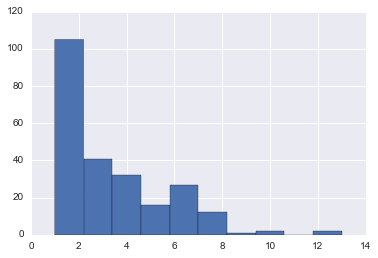

In [48]:
df_finalized['District'].value_counts().hist()

In [49]:
categorical_feats = ['Office Type', 'Race Type', 'Race Primary Election Date', 
                     'Gender', 'Race', 'Veteran?', 'LGBTQ?', 'Elected Official?',
                     'Self-Funder?', 'STEM?', 'Obama Alum?']

def categorize_features(df, cats):
    df_cols = df.columns.tolist()
    for cat in cats:
        if cat in df_cols:
            df[cat] = df[cat].astype('category')
    return df

In [50]:
df_finalized_cats = categorize_features(df_finalized, categorical_feats)

In [51]:
df_finalized_cats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 801 entries, Anthony White (Alabama) to Shirley Love
Data columns (total 16 columns):
State                         801 non-null object
District                      801 non-null object
Office Type                   801 non-null category
Race Type                     801 non-null category
Race Primary Election Date    801 non-null category
Primary Status                801 non-null object
Gender                        801 non-null category
Partisan Lean                 801 non-null float64
Primary %                     801 non-null float64
Race                          798 non-null category
Veteran?                      801 non-null category
LGBTQ?                        801 non-null category
Elected Official?             801 non-null category
Self-Funder?                  801 non-null category
STEM?                         801 non-null category
Obama Alum?                   800 non-null category
dtypes: category(11), float64(2), object(3)
m

From the info printout above, we see that all features except for 'State', 'District', and the output column 'Primary Status' (as well as the numerical features) have been converted to a categorical type, and the memory usage has dropped from 106.4 KB to 47.5 KB. I am considering dropping State and District as they would blow up the dimensionality of the model, although doing so would basically mean my model assumes that voters are the same everywhere, which flies in the face of the notion that "all politics is local". We'll see how the model performs under that assumption.

In [52]:
target = df_finalized['Primary Status']
df_no_location = df_finalized.drop(['State','District', 'Primary Status'], axis=1).copy()

In [53]:
df_no_location.info()

<class 'pandas.core.frame.DataFrame'>
Index: 801 entries, Anthony White (Alabama) to Shirley Love
Data columns (total 13 columns):
Office Type                   801 non-null category
Race Type                     801 non-null category
Race Primary Election Date    801 non-null category
Gender                        801 non-null category
Partisan Lean                 801 non-null float64
Primary %                     801 non-null float64
Race                          798 non-null category
Veteran?                      801 non-null category
LGBTQ?                        801 non-null category
Elected Official?             801 non-null category
Self-Funder?                  801 non-null category
STEM?                         801 non-null category
Obama Alum?                   800 non-null category
dtypes: category(11), float64(2)
memory usage: 28.7+ KB


In [54]:
X_no_loc = pd.get_dummies(df_no_location, drop_first=True)

In [55]:
X_no_loc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 801 entries, Anthony White (Alabama) to Shirley Love
Data columns (total 23 columns):
Partisan Lean                                     801 non-null float64
Primary %                                         801 non-null float64
Office Type_Representative                        801 non-null uint8
Office Type_Senator                               801 non-null uint8
Race Type_Special                                 801 non-null uint8
Race Primary Election Date_2018-03-06 00:00:00    801 non-null uint8
Race Primary Election Date_2018-03-20 00:00:00    801 non-null uint8
Race Primary Election Date_2018-05-08 00:00:00    801 non-null uint8
Race Primary Election Date_2018-05-15 00:00:00    801 non-null uint8
Race Primary Election Date_2018-05-22 00:00:00    801 non-null uint8
Race Primary Election Date_2018-06-05 00:00:00    801 non-null uint8
Race Primary Election Date_2018-06-12 00:00:00    801 non-null uint8
Race Primary Election Date_2018-06-26

In [4]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [ ]:
steps = [('imputer', DataFrameImputer(),
         ('rf', RandomForestClassifier())]
pipeline = Pipeline(steps)
parameters = [{'rf__n_estimators':[200], 
               'rf__criterion': ['gini', 'entropy'], 
               'rf__max_features':[6,12], 
               'rf__max_depth': [2,5,8], 
               'rf__min_samples_leaf': [1,3]}]
rf_gs = GridSearchCV(pipeline, parameters, cv=3, return_train_score=True, scoring='recall', n_jobs=-1, verbose=4)
rf_gs.fit(X_no_loc, y_train.values.reshape((y_train.size,)))